In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

citeseer_dataset = Planetoid("data", name="Citeseer", transform=NormalizeFeatures())

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
import torch.nn.functional as F
import torch_geometric.nn as nn_geo

class GCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()

        self.conv1 = nn_geo.GCNConv(in_channels=input_channels, out_channels=hidden_channels)
        self.conv2 = nn_geo.GCNConv(in_channels=hidden_channels, out_channels=output_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [23]:
citeseer_graph = citeseer_dataset[0].to(device)
input_channels = citeseer_dataset.num_features
hidden_channels = 32
output_channels = citeseer_dataset.num_classes

In [27]:
model = GCN(
    input_channels=input_channels,
    hidden_channels=hidden_channels,
    output_channels=output_channels
).to(device)

print(model)



GCN(
  (conv1): GCNConv(3703, 32)
  (conv2): GCNConv(32, 6)
)


In [28]:
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 200

In [29]:
for epoch in range(num_epochs):
    
    model.train()
    
    optimizer.zero_grad()
    out = model(citeseer_graph)
    
    loss = F.nll_loss(out[citeseer_graph.train_mask], citeseer_graph.y[citeseer_graph.train_mask])
    loss.backward()
    
    optimizer.step()
    
    # Get predictions on the training data
    pred_train = out.argmax(dim = 1)
    
    correct_train = (
        pred_train[citeseer_graph.train_mask] == citeseer_graph.y[citeseer_graph.train_mask]
    ).sum()
    
    acc_train = int(correct_train) / int(citeseer_graph.train_mask.sum())

    # Get predictions on validation data
    model.eval()

    pred_val = model(citeseer_graph).argmax(dim = 1)
    
    correct_val = (
        pred_val[citeseer_graph.val_mask] == citeseer_graph.y[citeseer_graph.val_mask]
    ).sum()
    
    acc_val = int(correct_val) / int(citeseer_graph.val_mask.sum())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1:03d}, \
               Train Loss: {loss:.3f}, \
               Train Acc: {acc_train:.3f} Val Acc: {acc_val:.3f}')

Epoch: 010,                Train Loss: 1.705,                Train Acc: 0.817 Val Acc: 0.650
Epoch: 020,                Train Loss: 1.567,                Train Acc: 0.825 Val Acc: 0.674
Epoch: 030,                Train Loss: 1.357,                Train Acc: 0.908 Val Acc: 0.692
Epoch: 040,                Train Loss: 1.196,                Train Acc: 0.867 Val Acc: 0.700
Epoch: 050,                Train Loss: 1.010,                Train Acc: 0.908 Val Acc: 0.700
Epoch: 060,                Train Loss: 0.805,                Train Acc: 0.942 Val Acc: 0.722
Epoch: 070,                Train Loss: 0.702,                Train Acc: 0.925 Val Acc: 0.716
Epoch: 080,                Train Loss: 0.645,                Train Acc: 0.950 Val Acc: 0.714
Epoch: 090,                Train Loss: 0.548,                Train Acc: 0.975 Val Acc: 0.716
Epoch: 100,                Train Loss: 0.500,                Train Acc: 0.950 Val Acc: 0.716
Epoch: 110,                Train Loss: 0.494,                Train Acc

In [30]:
model.eval()

pred = model(citeseer_graph).argmax(dim=1)
correct = (pred[citeseer_dataset.test_mask] == citeseer_graph.y[citeseer_graph.test_mask]).sum()
test_acc = int(correct)/int(citeseer_graph.test_mask.sum())

test_acc

0.716

In [31]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:,0], z[:,1], s=70, c=color, cmap="Set1")
    plt.show()

Node embedding shape:  torch.Size([3327, 6])


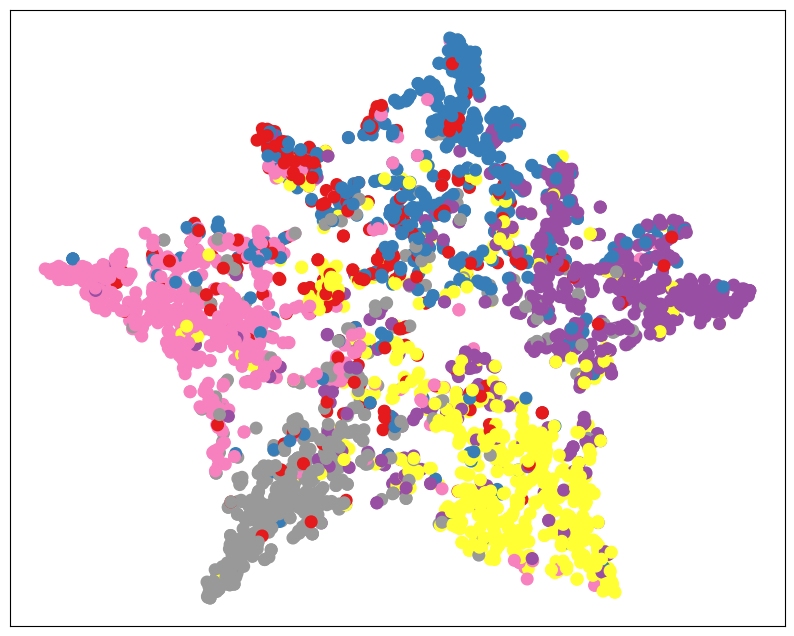

In [32]:
model.eval()
out = model(citeseer_graph)

print("Node embedding shape: ", out.shape)
visualize(out, color=citeseer_graph.cpu().y)